<img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width="80%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-398/578 Introducción al aprendizaje automático</h1>

<h4 align='center'><b>Tarea 3: Redes neuronales y ensamblados.</b></h4>


<h6 align='center'><b>Profesor:</b> Carlos Valle</h6>
<h6 align='center'><b>Ayudante:</b> Jean Aravena</h6>



<hr style="height:2px;border:none"/>

# **Tarea 3 📃**

## **Temas**  

* Redes neuronales.
* Ensamblados.
* Random Forest, XGBoost, CatBoost.


## **Formalidades** 

* Equipos de trabajo de 2 personas.
* El entregable debe ser este mismo Jupyter Notebook incluyendo todos los resultados, los gráficos realizados y las respuestas a las preguntas. 
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el Jupyter Notebook que entregarán.
* Formato de entrega: Subir a aula el Jupyter Notebook con el nombre NombreGrupo_Tarea_3_ML_2022_1
* Fecha de entrega y presentaciones: 22 de Julio. Hora límite de entrega: 14:30.
 

<hr style="height:2px;border:none"/>

La tarea se divide en 3 partes:

1.   Redes Neuronales.
2.   Ensamblados.
3.   Desafío.


La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo, solo son guías y pueden ser creativos al momento de resolver la tarea. También en algunas ocasiones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.

Recuerden intercalar su código con comentarios y utilizar celdas Markdown en caso de que sea necesario para realizar análisis, escribir fórmulas o realizar explicaciones que les parezca relevante para justificar sus procedimientos. 

Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en sí, en cambio la argumentación detrás de la elección será lo más ponderado.

*Se recomienda el uso de Google Colab para realizar la tarea.*

# Librerias 📚
 

Agregar cualquier otra librería que requiera para el desarrollo de la tarea.

In [ ]:
!pip install -q -U catboost
!pip install -q -U keras-tuner

In [ ]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Input, Dense, Layer, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, Loss
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

sns.set_theme()
warnings.filterwarnings('ignore')

# Utils ⚙️  

In [ ]:
print("Mounting your Google Drive ...")

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Path to your folder
path = '/content/drive/MyDrive/Machine Learning/Data'

Mounting your Google Drive ...
Mounted at /content/drive


In [ ]:
# Set all seed.
def set_all_seed(seed=0):
  """Set the same seed for all the libraries that we use."""
  np.random.seed(seed)
  tf.random.set_seed(seed)

# Elegir cualquier semilla y siempre que se pueda utilizarla
# random_state = SEED
SEED = 2022

set_all_seed(seed=SEED)

# 1.1) Redes Neuronales 💣

<img src="https://drive.google.com/uc?id=12fnVpIB_qDJx_OVty7aWT1Ftw2o9r1Hl" width="60%"/>

[Referencia](https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8)

Para la creación de redes neuronales generalmente existen dos bandos:


*   `Pytorch`
*   `Tensorflow`

Por un lado, tenemos a `Pytorch` que es mayormente utilizado en investigación y por otro lado tenemos a `Tensorflow` que es mayormente utilizado en la industria. Ambos tienen la misma capacidad de abstracción y ambos son ampliamente aceptados y poseen una gran comunidad que los respalda.

Si nos vamos a una página bastante conocida como lo es [Papers With Code](https://paperswithcode.com/) podemos ver que desde la fecha `2018-03-01` hasta `2022-03-31` existe una tendencia creciente para el uso de `Pytorch` en términos de utilización en nuevos papers, es por ello por lo que en general si se va a realizar investigación se recomienda `Pytorch`, pero ambos son útiles y si sabes uno se hace más fácil cambiarse de uno a otro. En introducción a las redes neuronales se utiliza `Tensorflow`, es por ello que también emplearemos ese framework en esta tarea, pero como se mencionó anteriormente no importa mucho cual aprendas porque te puedes cambiar cuando sea necesario.


<img src="https://drive.google.com/uc?id=1xVqc0kPI1TXmhMmsMJnxOiUsGAaqiYGP" width="80%"/>


[Referencia](https://paperswithcode.com/trends)

## Carga y exploración de la data

In [ ]:
# Cargar la data que corresponde a un csv
PATH_TO_CSV = os.path.join(path, "tarea_3_house_price.csv")
df_data = pd.read_csv(PATH_TO_CSV)

<img src="https://drive.google.com/uc?id=13v7iUc8zmqlQ46aMfbtQ5dIEtDcdiNYx" width="50%"/>


Para la primera parte de la tarea trabajaremos con un dataset muy clásico en ML el cual es [House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction), que viene de `Kaggle`.

La data corresponde a 21.613 instancias las cuales tienen relación con precios de casas en dólares.

El dataset cuenta con 20 features las cuales están diseñadas para identificar ciertos patrones y con ello tratar de predecir el precio de una casa.

Features:

* `id`: Unique ID for each home sold
* `date`: Date of the home sale
* `bedrooms`: Number of bedrooms
* `bathrooms`: Number of bathrooms, where .5 accounts for a room with a toilet  but no shower
* `sqft_living`: Square footage of the apartments interior living space
* `sqft_lot`: Square footage of the land space
* `floors`: Number of floors
* `waterfront`: A dummy variable for whether the apartment was overlooking the waterfront or not
* `view`: An index from 0 to 4 of how good the view of the property was
* `condition`: An index from 1 to 5 on the condition of the apartment,
* `grade`: An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
* `sqft_above`: The square footage of the interior housing space that is above ground level
* `sqft_basement`: The square footage of the interior housing space that is below ground level
* `yr_built`: The year the house was initially built
* `yr_renovated`: The year of the house’s last renovation
* `zipcode`: What zipcode area the house is in
* `lat`: Lattitude
* `long`: Longitude
* `sqft_living15`: The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15`: The square footage of the land lots of the nearest 15 neighbors

Target:
* `price`: Price of each home sold

**Como es usual realice un pequeño EDA (Exploratory Data Analysis). Comente los resultados obtenidos** [2 Pts]

In [ ]:
### START CODE HERE ###
# Mostrar el numero de ejemplos que tenemos
print(f"Number of examples: {len(df_data)}")

# Mostrar las dimensiones de la data
print(f"Shape of the data: {df_data.shape}")

Number of examples: 21613
Shape of the data: (21613, 21)


In [ ]:
# Mostrar los primeros cinco elementos de la data
df_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# Mostrar los ultimos cinco elementos de la data
df_data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [ ]:
# Obtener el tipo de dato de cada columna
df_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [ ]:
# Generar estadisticas tipicas por columna (Inluye solo valores numericos)
# Si quieres incluir los valores categoricos (strings) tienes que utilizar
# include="all" -> df_data.describe(include="all")
df_data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [ ]:
# Contar la cantidad de null en las columnas (si hubieran muchos habria que buscar alguna forma de lidear con ello). 
df_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Gráficos

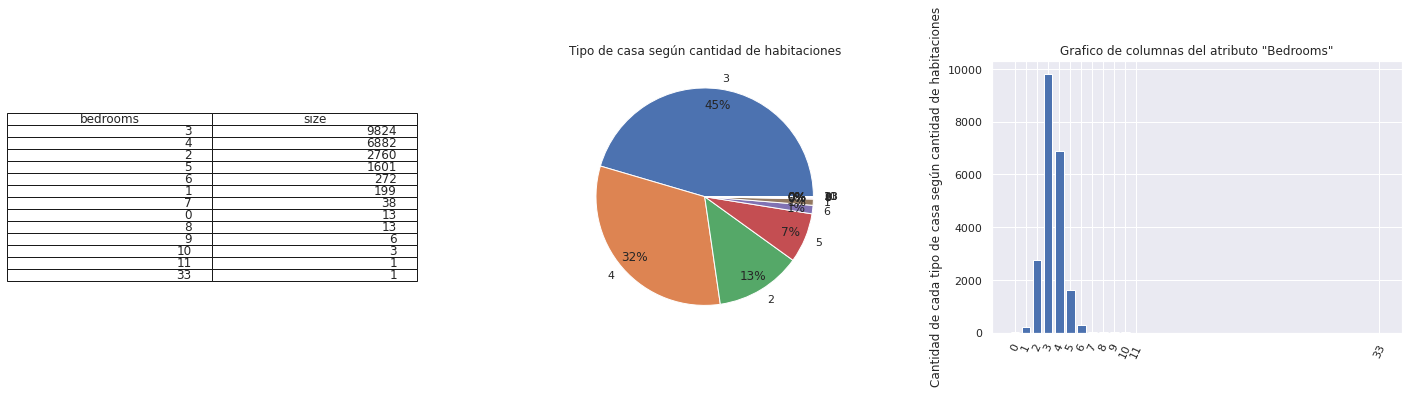

In [ ]:
### BEDROOMS ###
x = pd.DataFrame(df_data["bedrooms"])
grouped_data = x.groupby(x.columns.tolist(),as_index=False).size()
sorted_data = grouped_data.sort_values("size", ascending=False)
labels = list(sorted_data["bedrooms"])
aob = list(sorted_data["size"])

fig, axs = plt.subplots(1, 3, figsize = (25,5))

fig.patch.set_visible(False)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].table(cellText=sorted_data.values, colLabels=sorted_data.columns, loc='center')

axs[1].set_title('Tipo de casa según cantidad de habitaciones')
axs[1].pie(x.value_counts(), labels=labels, autopct='%1.0f%%', pctdistance=0.85)

axs[2].bar(labels, aob, tick_label=labels)
axs[2].set_ylabel('Cantidad de cada tipo de casa según cantidad de habitaciones')
axs[2].set_title('Grafico de columnas del atributo "Bedrooms"')
for tick in axs[2].get_xticklabels():
    tick.set_rotation(65)

plt.grid(True)
fig.show()

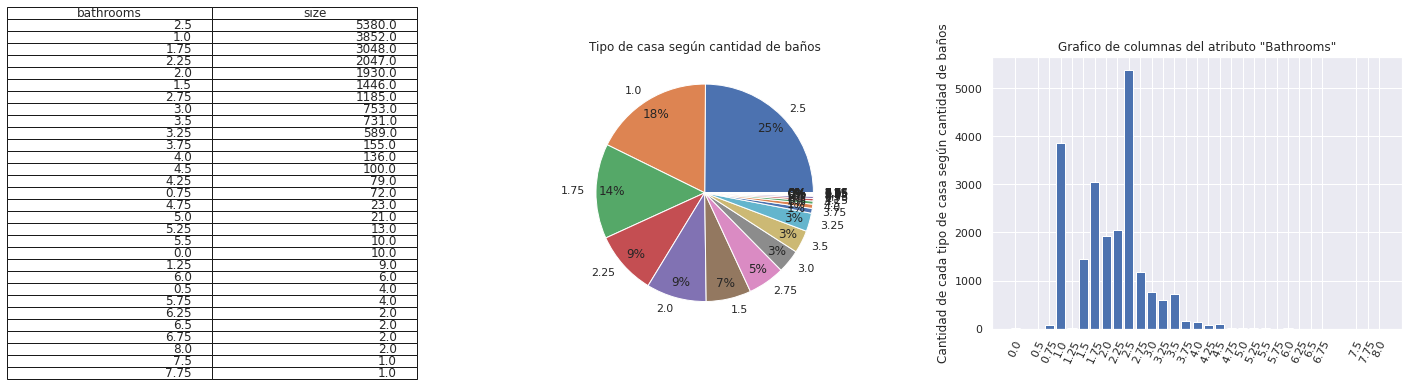

In [ ]:
### BATHROOMS ###
x = pd.DataFrame(df_data["bathrooms"])
grouped_data = x.groupby(x.columns.tolist(),as_index=False).size()
sorted_data = grouped_data.sort_values("size", ascending=False)
labels = list(sorted_data["bathrooms"])
aob = list(sorted_data["size"])

fig, axs = plt.subplots(1, 3, figsize = (25,5))

fig.patch.set_visible(False)
axs[0].axis('off')
axs[0].axis('tight')
axs[0].table(cellText=sorted_data.values, colLabels=sorted_data.columns, loc='center')

axs[1].set_title('Tipo de casa según cantidad de baños')
axs[1].pie(x.value_counts(), labels=labels, autopct='%1.0f%%', pctdistance=0.85)

axs[2].bar(labels, aob, width=0.2, tick_label=labels)
axs[2].set_ylabel('Cantidad de cada tipo de casa según cantidad de baños')
axs[2].set_title('Grafico de columnas del atributo "Bathrooms"')
for tick in axs[2].get_xticklabels():
    tick.set_rotation(65)

plt.grid(True)
fig.show()

      sqft_living  size
133          1300   138
156          1400   135
168          1440   133
232          1660   129
76           1010   129
...           ...   ...
470          2456     1
473          2473     1
475          2478     1
477          2481     1
1037        13540     1

[1038 rows x 2 columns]


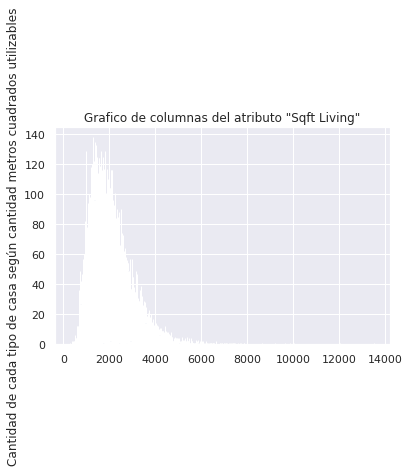

In [ ]:
### SQUARE FEET LIVING ###
x = pd.DataFrame(df_data["sqft_living"])
grouped_data = x.groupby(x.columns.tolist(),as_index=False).size()
sorted_data = grouped_data.sort_values("size", ascending=False)
labels = list(sorted_data["sqft_living"])
aob = list(sorted_data["size"])

plt.bar(labels, aob)#, color='blue')
plt.ylabel('Cantidad de cada tipo de casa según cantidad metros cuadrados utilizables')
plt.title('Grafico de columnas del atributo "Sqft Living"')
print(sorted_data)
plt.show()

## Preprocesamiento

**Divida la data en training/validation/testing considerando un split 80/10/10 y realice un preprocesamiento a la data** [2 Pts] 

In [ ]:
# Preprocesamiento (se quita date para efectos de uso con tensorflow)
df_data_wdate = df_data
df_data = df_data.drop('date', axis=1)

# Dividir la data considerando el split indicado anteriormente

# 80:10:10 para train:valid:test en el dataset
X = df_data

# Primero separamos 80:20 entrenamiento:test
df_train, df_test = train_test_split(X, test_size=0.2 , random_state=SEED)

# Luego separamos el test set en 10:10 valid:test. 
# Consideramos test_size como 0.5 (50% de los datos que quedaron anteriormente)

df_valid, df_test = train_test_split(df_test, test_size=0.5 , random_state=SEED)

print(df_train.shape, df_valid.shape , df_test.shape)

(17290, 20) (2161, 20) (2162, 20)


## Formas de crear una red neuronal

Existen tres formas distintas para crear una red neuronal utilizando `Tensorflow`:


1.   `Sequential API`
2.   `Functional API`
3.   `Model Subclassing`


Ordenados de menor a mayor en términos de flexibilidad, pero con el costo de trabajar a más bajo nivel.




### ¿Cómo preparar la data para utilizarla en una red neuronal?


Antes de crear la red aprenderemos a cómo preparar la data para ser utilizada posteriormente. Si bien existen múltiples formas, veremos el estándar que tiene Google en sus [tutoriales](https://www.tensorflow.org/tutorials) de `Tensorflow`. Lo cual consiste en hacer uso de [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/DatasetSpec)

**Siga los pasos indicados a continuación considerando la data** [1 Pts]

Separe cada dataframe en features y target.


In [ ]:
### START CODE HERE ###
y_train = df_train.pop("price")
X_train = df_train

y_valid = df_valid.pop("price")
X_valid = df_valid

y_test = df_test.pop("price")
X_test = df_test

In [ ]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_valid_scaled = std_scaler.transform(X_valid)
X_test_scaled = std_scaler.transform(X_test)

In [ ]:
std_scaler_y = StandardScaler()
y_train_scaled = std_scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_valid_scaled = std_scaler_y.transform(y_valid.values.reshape(-1,1))
y_test_scaled = std_scaler_y.transform(y_test.values.reshape(-1,1))

Crear los dataset de entrenamiento, validacion y testing utilizando `tf.data.Dataset.from_tensor_slices` considerando como parámetro la tupla X, y. Ejemplo: `tf.data.Dataset.from_tensor_slices(X_train.values, y_train.values)`


In [ ]:
### START CODE HERE ###
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid_scaled))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))

Podemos mostrar la estructura del dataset con un print o bien llamando a la variable.

In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(19,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.float64, name=None))>

También podemos mostrar un elemento en específico del dataset.

In [ ]:
for (X, y) in train_dataset:
  print(X)
  print(y)
  break

tf.Tensor(
[ 0.38792897 -0.41284416  1.47452011  0.54251354 -0.12632642  0.01462349
 -0.08837804  0.98801434  0.90320667  1.14721437 -0.03445006  1.18620832
  0.23999874 -0.20859579 -0.9494367  -0.21020386  1.13731909  0.22057317
 -0.08638016], shape=(19,), dtype=float64)
tf.Tensor([0.39739091], shape=(1,), dtype=float64)


`Tensorflow` funciona en base a tensores. Un `tensor` no es más ni menos que una matriz con cero o más dimensiones. Un `tensor` de dimension cero se llama escalar


En este caso vamos a mostrar tensores de 0, 1 y 2 dimensiones para comprender como varia el valor de shape en cada caso.

In [ ]:
tensor_zero_dimension = tf.Variable(1, tf.int32)
tensor_zero_dimension

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=1>

Si el `tensor` es un escalar entonces vamos a tener `shape=()`.

In [ ]:
tensor_one_dimension = tf.Variable([2, 3], tf.int32)
tensor_one_dimension

<tf.Variable 'Variable:0' shape=(2,) dtype=int32, numpy=array([2, 3], dtype=int32)>

Si el `tensor` es de una dimension vamos a tener `shape=(2, )` lo que indica que tenemos un `tensor` con una dimension y dos elementos.

In [ ]:
tensor_two_dimension = tf.Variable([[1, 2], [2, 3]], tf.int32)
tensor_two_dimension

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[1, 2],
       [2, 3]], dtype=int32)>

Si el `tensor` es de dos dimensiones vamos a tener `shape=(2, 2)` lo que indica que tenemos un `tensor` con dos dimension y dos elementos.


En conclusión si tenemos `shape=(x, y)` el valor `x` corresponde a la cantidad de elementos que existe en el tensor e `y` corresponde a la dimensionalidad de este. Cuando `shape=()` significa que tenemos un escalar lo que es igual a tener un tensor de dimensionalidad cero.

En caso de que queramos obtener el valor de un `Tensor` como usualmente se aprecia en `numpy`, tenemos que utilizar `X.numpy()` o bien `y.numpy()`.

In [ ]:
for (X, y) in train_dataset:
  print(X.numpy())
  print(y.numpy())
  break

[ 0.38792897 -0.41284416  1.47452011  0.54251354 -0.12632642  0.01462349
 -0.08837804  0.98801434  0.90320667  1.14721437 -0.03445006  1.18620832
  0.23999874 -0.20859579 -0.9494367  -0.21020386  1.13731909  0.22057317
 -0.08638016]
[0.39739091]


Continuando con el tutorial de la preparación de la data, el primer paso es tener el dataset en la forma de tupla `(X, y)`. Como ya tenemos el dataset de la forma correcta, el siguiente paso es preparar el dataset para ser usado por la red neuronal. Para ello utilicen la siguiente funcion:

In [ ]:
def preprocess_dataset(dataset, batch_size, size):
  """Preprocess dataset.

    :param dataset: Dataset para prepararlo para el entrenamiento
    :type dataset: tensorflow.python.data.ops.dataset_ops.TensorSliceDataset
    :param batch_size: Tamano del batch a utilizar para entrenamiento
    :type batch_size: int
    :param table_name: Tamano del dataset
    :type table_name: int
    :return: Dataset listo para ser usado por la red neuronal
    :rtype: tensorflow.python.data.ops.dataset_ops.TensorSliceDataset
  """

  AUTOTUNE = tf.data.AUTOTUNE

  dataset = dataset.shuffle(size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=AUTOTUNE)
  dataset = dataset.cache()

  return dataset

**De que sirve la funcion anterior** [1 Pts] 

`Comentario`: La función aplica una serie de "medidas" sobre el dataset y lo prepara para la red neuronal, lo que hace es que le indica a esta todo aquello a tener en consideración durante la fase de entrenamiento.

In [ ]:
### START CODE HERE ###
pp_train_dataset = preprocess_dataset(train_dataset, 64, 17290)
pp_valid_dataset = preprocess_dataset(valid_dataset, 64, 2161)
pp_test_dataset = preprocess_dataset(test_dataset, 64, 2162)

**Explique el significado del tamano del batch (`batch size`) en la implementación moderna del algoritmo BP (`back-propagation`). ¿Qué valor recomendaría si su conjunto de entrenamiento es de 10.000 ejemplos? ¿Qué valor recomendaría si su conjunto de entrenamiento es de 1.000.000 de ejemplos?** [1 Pts]

`Respuesta:`
Batch Size es el numero de datos que tiene cada iteración de un ciclo (epoch), esto es util en Back Propagation porque la red neuronal puede ajustar sus parametros más de una vez. Además, cuando se tienen grandes cantidades de datos, la red neuronal tarda más en pasar por cada ciclo, si dividimos los ciclos en iteraciones con un numero de datos más pequeño (batches) ya no es necesario cargar todos los datos en la memoria al mismo tiempo y la red neuronal se entrena más rapido.

En este artículo de Medmium (https://towardsdatascience.com/backpropagation-from-scratch-on-mini-batches-e6efdaa281a2), se ve como el autor utiliza mini batches ```(batch_size = 50)```para una matriz de 10.000 x 10.000, por lo tanto para 1.000.000 ejemplos, podríamos asumir que el mismo método se puede aplicar con un ```batch_size = 5000```.


Finalmente, tenemos listo el dataset para ser utilizado por la red neuronal.

### Sequential API

*Crear* y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


Usando [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) [2 Pts]




*Para ello se puede apoyar en la función [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) de `Tensorflow`.*

```
model = Sequential([
  Input(..., name=''),
  Dense(units=128, activation='relu', ..., name=''),
  Dense(units=128, activation='relu', ..., name=''),
  ...
  Dense(units=1, ..., name='')
])
```

Y compile el modelo utilizando model.compile de `Tensorflow` considerando como base el siguiente ejemplo:

```
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
```
Para mayor información se recomienda revisar el siguiente [link](https://www.tensorflow.org/guide/keras/train_and_evaluate#the_compile_method_specifying_a_loss_metrics_and_an_optimizer).

Utilizar:
* `optimizer` = `Adam(learning_rate=1e-3)` con los parámetros por defecto
* `loss` = `Mean Squared Error`
* `metrics` = `Mean Squared Error`

In [ ]:
### START CODE HERE ###
s_model = Sequential([
                    Input(shape=(19,), name="input_layer"),
                    Dense(16, activation='relu', name="hidden_layer1"),
                    Dense(16, activation='relu', name="hidden_layer2"),
                    Dense(16, activation='relu', name="hidden_layer3"),
                    Dense(1, activation='linear', name="output_layer")
])

s_model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = "mse",
    metrics = ["mse"]
)

**Calcule la cantidad de parámetros entrenables de esta red y luego verifique su resultado utilizando `model.summary()`** (Cuando se pide el número de parámetros explicitar como llego a ese valor, que multiplicaciones o sumas tuvo que realizar) [0.5 Pts]

```
19*16 + 0  = 320
16*16 + 16 = 272
16*16 + 16 = 272
16*1  + 1  = 17

320 + 272*2 + 17 = 881
```
`Número de Parámetros` = 881

In [ ]:
### START CODE HERE ###
s_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 16)                320       
                                                                 
 hidden_layer2 (Dense)       (None, 16)                272       
                                                                 
 hidden_layer3 (Dense)       (None, 16)                272       
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


**Muestre la estructura de la red utilizando la función `tf.keras.utils.plot_model`** [1 Pts]

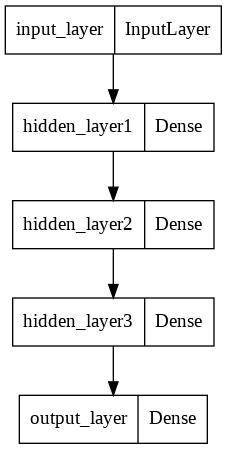

In [ ]:
### START CODE HERE ###
structure = tf.keras.utils.plot_model(s_model)
structure

#### ¿Cómo crear funciones de perdida?

Para probar los siguientes apartados vamos a crear un dataset muy sencillo que corresponde a 100 datos extraídos de la siguiente ecuación:

$$y = 2x + 1$$

e intentaremos predecir $x=100$, lo cual debería ser $y=201$ o muy cercano a este valor.

In [ ]:
# Create a dummy dataset
x = tf.linspace(start=1, stop=100, num=100)
y = tf.multiply(x, 2) + 1

`Tensorflow` da bastante flexibilidad y podemos crear las funciones de pérdidas que queramos, en este caso creare la funcion de RMSE.


In [ ]:
# With subclassing
class MyCustomRMSEV1(Loss):

  def __init__(self, **kwargs):
    super(MyCustomRMSEV1, self).__init__(**kwargs)

  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV1())
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[203.01099]]


In [ ]:
# Without subclassing
def MyCustomRMSEV2():

  def loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse

  return loss

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV2())
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[202.99008]]


En la versión que no utiliza subclassign le podemos pasar parámetros adicionales a la funcion, como por ejemplo:


In [ ]:
def MyCustomRMSEV3(factor):

  def loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / factor

  return loss

In [ ]:
model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomRMSEV3(factor=100))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[202.96544]]


**Existe una funcion de perdida para regresión llamada Huber, investigar cómo se calcula, impleméntela usando `Tensorflow` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente** [1 Pts]




`Huber`: 

Huber Loss funciona de la siguiente manera:
```
loss = 0.5 * x^2                  if |x| <= d
loss = 0.5 * d^2 + d * (|x| - d)  if |x| > d
````
Donde d es delta.

In [ ]:
### START CODE HERE ###
def MyCustomHuberLoss(delta=1.0):

  def loss(y_true, y_pred):
    huber = tf.keras.losses.Huber(reduction="auto")
    h = huber(y_true, y_pred)
    return h

  return loss

model = Sequential([Dense(units=1, input_shape=[1])])
model.compile(optimizer='adam', loss=MyCustomHuberLoss())
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[202.1088]]


#### ¿Cómo crear funciones de activación?

También podemos crear funciones de activación utilizando `Tensorflow`. Para ello se muestra el ejemplo de la funcion de activación sigmoidal.

In [ ]:
def MySigmoid(x):
  return 1/ (1 + tf.math.exp(-x))

model = Sequential([Dense(units=1, input_shape=[1], activation=MySigmoid)])
model.compile(optimizer='adam', loss=MyCustomHuberLoss(delta=0.5))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[1.]]


**Identifique la expresión matemática que computa la funcion de activación `LeakyRelu` e impleméntela utilizando `Tensorflow`. Utilice como funcion de activación `LeakyRelu` con cualquier valor de `alpha` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente** [1 Pts]


`LeakyRelu`:

LeakyRelu funciona de la siguiente manera:
```
f(x) = alpha * x if x < 0
f(x) = x if x >= 0
```

In [ ]:
### START CODE HERE ###
def MyLeakyRelu(alpha=0.1):
  return tf.keras.layers.LeakyReLU(alpha=0.1)

model = Sequential([Dense(units=1, input_shape=[1], activation=MyLeakyRelu(alpha=0.1))])
model.compile(optimizer='adam', loss=MyCustomHuberLoss(delta=0.5))
model.fit(x, y, epochs=1000, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[202.97928]]


#### ¿Cómo crear capas personalizadas?

Para crear capas personalizadas tenemos que hacer subclassing a la clase `Layer`. En este caso se replica parte de la capa `Dense` que utilizamos anteriormente.

In [ ]:
class MyCustomDenseV1(Layer):

  def __init__(self, units=16, activation=None):
    """Inicializar los atributos de la instancia"""
    super(MyCustomDenseV1, self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    """Crear el 'template' de la capa (pesos)"""
     # Initialize the weights
    w_init = tf.random_normal_initializer()
    self.w = tf.Variable(name="kernel",
                        initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),
                        trainable=True)
    b_init = tf.zeros_initializer()
    # Initialize the biases
    self.b = tf.Variable(name="bias",
                         initial_value=b_init(shape=(self.units, ), dtype='float32'),
                         trainable=True)
  
  def call(self, inputs):
    """Definir la operaciones que realiza la capa desde inputs a outputs"""
    return self.activation(tf.matmul(inputs, self.w) + self.b)

In [ ]:
model = Sequential([Input(shape=(1, )), MyCustomDenseV1(units=1)])
model.compile(optimizer=Adam(learning_rate=1e-3), loss=MyCustomRMSEV3(factor=10))
model.fit(x, y, epochs=500, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[192.6536]]


**Crear una capa densa con el nombre `MyCustomDenseV2` que compute lo siguiente: [1 Pts]
$$y = ax^3 * bx^2 - cx + d $$** 
Esto puede que no tenga mucho sentido en la práctica, es solo para que se familiaricen un poco con el código.

Utilice su capa `MyCustomDenseV2` y prediga el valor para $x=100$ considerando el dataset dummy creado anteriormente

In [ ]:
### START CODE HERE ###
class MyCustomDenseV2(Layer):

  def __init__(self, units=16, activation=None):
    """Inicializar los atributos de la instancia"""
    super(MyCustomDenseV2, self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)

  def build(self, input_shape):
    """Crear el 'template' de la capa (pesos)"""
    # Initialize the weights
    a_init = tf.random_normal_initializer()
    self.a = tf.Variable(name="kernel_a",
                        initial_value=a_init(shape=(input_shape[-1], self.units), dtype='float32'),
                        trainable=True)
    b_init = tf.random_normal_initializer()
    self.b = tf.Variable(name="kernel_b",
                        initial_value=b_init(shape=(input_shape[-1], self.units), dtype='float32'),
                        trainable=True)
    c_init = tf.random_normal_initializer()
    self.c = tf.Variable(name="kernel_c",
                        initial_value=c_init(shape=(input_shape[-1], self.units), dtype='float32'),
                        trainable=True)
    d_init = tf.zeros_initializer()
    # Initialize the biases
    self.d = tf.Variable(name="bias",
                        initial_value=d_init(shape=(self.units, ), dtype='float32'),
                        trainable=True)
  
  def call(self, inputs):
    """Definir la operaciones que realiza la capa desde inputs a outputs"""
    return self.activation(tf.matmul(inputs, self.a)**3 * tf.matmul(inputs, self.b)**2 - tf.matmul(inputs, self.c) + self.d)

model = Sequential([Input(shape=(1, )), MyCustomDenseV2(units=1)])
model.compile(optimizer=Adam(learning_rate=1e-3), loss=MyCustomRMSEV3(factor=10))
model.fit(x, y, epochs=500, verbose=0)

print(f"Prediction {model.predict([101.0])}")

Prediction [[219.06699]]


**Calcular la cantidad de parámetros de su modelo anterior. Explicar su resultado** [0.5 Pts]

La cantidad de parámetros será 4, puesto que tenemos una sola capa, con una neurona y 4 parámetros (a, b, c y d) en la expresión matemática que computa dicha capa.

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_custom_dense_v2 (MyCusto  (None, 1)                4         
 mDenseV2)                                                       
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


`Número de parámetros`: 4

#### ¿Qué son los callbacks en TensorFlow?

**Existen multiples `Callbacks` disponibles en `Tensorflow` e incluso uno puede crear `Callbacks` personalizados. Defina la utilidad de los `Callbacks` y averiguar cómo funciona el callback [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) y [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint). Finalmente cree una lista con ambos callbacks para posteriormente ser pasados al entrenamiento de la red** [1 Pts]

*   `Callbacks`: Para llamar a una función en cada epoch.
*   `EarlyStopping`: Para detener el entrenamiento cuando no hay progreso en el entrenamiento o ya convergió lo que más puede y está comenzando a hacer overfitting.
*   `ModelCheckpoint`: Se usa para guardar el modelo o sus pesos para algún checkpoint en un archivo.



Para `EarlyStopping` utilice los parámetros `monitor, patience y restore_best_weights`. Elija un valor apropiado para `monitor y patience`, el parámetro `restore_best_weights` déjelo en True.


Para `ModelCheckpoint` utilice los parámetros `filepath, monitor, save_best_only y save_weights_only`. Elija un valor para los parámetros `filepath y monitor`, los parámetros `save_best_only, save_weights_only` déjelos en True.


In [ ]:
### START CODE HERE ###
checkpoint_filepath = '/tmp/checkpoint'
callback_list =  [
                      EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                      ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, save_weights_only=True)
]

#### Entrenamiento de la primera red neuronal

Para entrenar una red la forma más sencilla es utilizar el metodo `model.fit`. También se puede personalizar lo que sucede en el model.fit pero eso quedara para el siguiente curso de introducción a las redes neuronales. Si les interesa saber acerca del tema les dejo el siguiente [link](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

Entrene su modelo utilizando `model.fit`. Defina un numero de epoch acorde al problema, utilice los callbacks definidos anteriormente y los dataset (entrenamiento y validacion) que ya tiene listos para ser pasados por la red. Guardar el resultado en una variable, puede ser llamada `history`.

In [ ]:
### START CODE HERE ###
history = s_model.fit(pp_train_dataset, validation_data=pp_valid_dataset, epochs=50, verbose=2, callbacks=callback_list)

Epoch 1/50
271/271 - 1s - loss: 0.3540 - mse: 0.3540 - val_loss: 0.2681 - val_mse: 0.2681 - 1s/epoch - 5ms/step
Epoch 2/50
271/271 - 0s - loss: 0.2371 - mse: 0.2371 - val_loss: 0.2336 - val_mse: 0.2336 - 475ms/epoch - 2ms/step
Epoch 3/50
271/271 - 0s - loss: 0.2100 - mse: 0.2100 - val_loss: 0.2127 - val_mse: 0.2127 - 396ms/epoch - 1ms/step
Epoch 4/50
271/271 - 0s - loss: 0.1904 - mse: 0.1904 - val_loss: 0.1990 - val_mse: 0.1990 - 398ms/epoch - 1ms/step
Epoch 5/50
271/271 - 0s - loss: 0.1753 - mse: 0.1753 - val_loss: 0.1885 - val_mse: 0.1885 - 434ms/epoch - 2ms/step
Epoch 6/50
271/271 - 0s - loss: 0.1638 - mse: 0.1638 - val_loss: 0.1789 - val_mse: 0.1789 - 437ms/epoch - 2ms/step
Epoch 7/50
271/271 - 0s - loss: 0.1540 - mse: 0.1540 - val_loss: 0.1703 - val_mse: 0.1703 - 387ms/epoch - 1ms/step
Epoch 8/50
271/271 - 0s - loss: 0.1460 - mse: 0.1460 - val_loss: 0.1666 - val_mse: 0.1666 - 409ms/epoch - 2ms/step
Epoch 9/50
271/271 - 0s - loss: 0.1410 - mse: 0.1410 - val_loss: 0.1629 - val_mse: 

**Grafique las curvas de entrenamiento. Comente el grafico** [1 Pts]

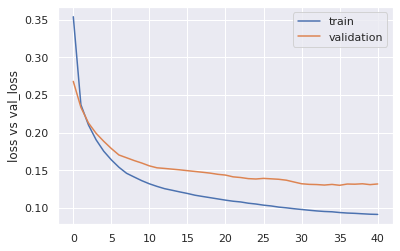

In [ ]:
### START CODE HERE ###
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.ylabel("loss vs val_loss")
plt.legend()
plt.show()

Identifique en que parte de la siguiente figura se encuentra su entrenamiento: 

<img src="https://drive.google.com/uc?id=1kecseaITvJeG45WNePflLn_u3sOYUyq4" width="50%"/>

**En caso de que se encuentre en la parte izquierda o derecha que tiene que recomendaría hacer?** [1 Pts]

`Respuesta`: se detuvo gracias al early stopping, por lo que no se encuentra en ninguno de los dos lados mencionados. En caso de que estuviese en underfitting, expandir la variabilidad del modelo es una opción arquitectura de la red neuronal). En caso de overfitting, scaling y descomplejizar el modelo.

**Compute el resultado de su modelo para el conjunto de testing** [1 Pts]

In [ ]:
### START CODE HERE ### 
test_score = s_model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print('Test Loss:', test_score[0])

68/68 [==============================] - 0s 2ms/step - loss: 0.1181 - mse: 0.1181
Test Loss: 0.11811594665050507


#### ¿Cómo seteamos los hiperparámetros en una red neuronal?

**Para setear los hiperparámetros en `Tensorflow` tenemos algo que se llama [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). Investigue como utilizarlo y encuentre los mejores hiperparámetros para su modelo anterior** [2 Pts]

In [ ]:
### START CODE HERE ### 
'''
tuner = kt.Hyperband(s_model,
                     objective='val_loss',
                     max_epochs=50)
                     
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_scaled, validation_data=pp_valid_dataset, epochs=50, callbacks=[stop_early])
'''

"\ntuner = kt.Hyperband(s_model,\n                     objective='val_loss',\n                     max_epochs=50)\n                     \nstop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)\ntuner.search(X_train_scaled, validation_data=pp_valid_dataset, epochs=50, callbacks=[stop_early])\n"

**Muestre los mejores hiperparámetros obtenidos para la red neuronal, cree de nuevo la red y reentrénela usando los mejores hiperparámetros. Muestre las curvas de entrenamiento y finalmente evalúe su red con el conjunto de testing** [1 Pts]


In [ ]:
### START CODE HERE ### 


### Functional API

#### Entrenamiento

Crear y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


usando [Functional API](https://www.tensorflow.org/guide/keras/functional?hl=es-419) [2 Pts]


Compilar el modelo de la misma forma que en el apartado de `Sequential API`

In [ ]:
### START CODE HERE ###
tf.keras.backend.clear_session()  # Reseteo sencillo

inputs = Input(shape=(19,), name='input_layer')
x = Dense(16, activation='relu', name="hidden_layer1")(inputs)
x = Dense(16, activation='relu', name="hidden_layer2")(x)
x = Dense(16, activation='relu', name="hidden_layer3")(x)
outputs = Dense(1, name='output_layer')(x)

f_model = Model(inputs=inputs, outputs=outputs, name='Functional_API_Model')

f_model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = "mse",
    metrics = ["mse"]
)

**Compruebe que al utilizar `Functional API` se obtiene la misma cantidad de parámetros entrenables que cuando se utiliza `Sequential API`. Realice el entrenamiento de modelo**  [1 Pts]


In [ ]:
### START CODE HERE ###
f_model.summary()
history = f_model.fit(pp_train_dataset, validation_data=pp_valid_dataset, epochs=50, verbose=2, callbacks=callback_list)

Model: "Functional_API_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 19)]              0         
                                                                 
 hidden_layer1 (Dense)       (None, 16)                320       
                                                                 
 hidden_layer2 (Dense)       (None, 16)                272       
                                                                 
 hidden_layer3 (Dense)       (None, 16)                272       
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
271/271 - 1s - loss: 0.3755 - mse: 0.

**Grafique la curva de entrenamiento y comente los resultados** [0.5 Pts]

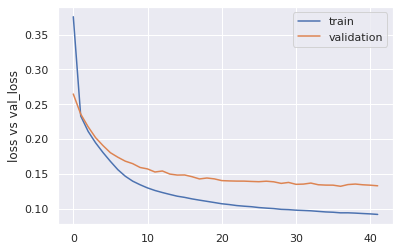

In [ ]:
### START CODE HERE ###
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.ylabel("loss vs val_loss")
plt.legend()
plt.show()

Se parece mucho a Sequential API, pero el proceso fue menos engorroso.

Parece bastante similar `Sequential API` y `Functional API` la diferencia es que con `Functional API` podemos tener modelos más complejos que tengan por ejemplo skip connections o bien que tengan múltiples entradas y/o salidas (**Lo que puede o no servir para el desafío**)

**Investigar la utilidad de las skip connections en redes neuronales y agregue algunas skip connections al modelo anterior, puede agregar más capas si lo requiere** [2 Pts]

`Skip Connections`: Las Skip Connections se utilizan generalmente cuando se tiene algun problema de convergencia en la red neuronal (gradient explosions, etc.) 

In [ ]:
### START CODE HERE ###
tf.keras.backend.clear_session()  # Reseteo sencillo

inputs = Input(shape=(19,), name='input_layer')
x = Dense(16, activation='relu', name="hidden_layer1")(inputs)
x = Dense(16, activation='relu', name="hidden_layer2")(x)
x = Dense(16, activation='relu', name="hidden_layer3")(x)
outputs = Dense(1, name='output_layer')(x)
z = Add()([inputs, outputs])

sf_model = Model(inputs=inputs, outputs=z, name='S_Functional_API_Model')

sf_model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = "mse",
    metrics = ["mse"]
)

**Muestre que su modelo si cuenta con skip connections utilizando `tf.keras.utils.plot_model`** [0.5 Pts]

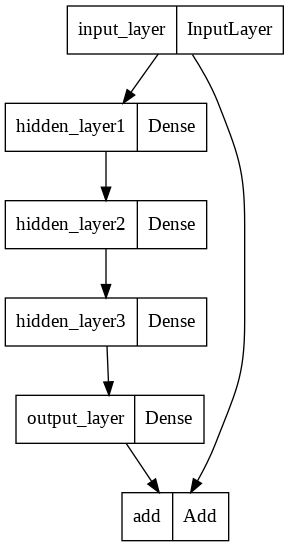

In [ ]:
### START CODE HERE ###
functional = tf.keras.utils.plot_model(sf_model)
functional

**Entrene este modelo, grafique las curvas de entrenamiento y evalúe el modelo con el conjunto de testing** [0.5 Pts]


In [ ]:
### START CODE HERE ### 
checkpoint_filepath = '/tmp/checkpoint'
callback_list =  [
                      EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                      ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, save_weights_only=True)
]
sf_model.summary()
history = sf_model.fit(pp_train_dataset, validation_data=pp_valid_dataset, epochs=50, verbose=2, callbacks=callback_list)

Model: "S_Functional_API_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 19)]         0           []                               
                                                                                                  
 hidden_layer1 (Dense)          (None, 16)           320         ['input_layer[0][0]']            
                                                                                                  
 hidden_layer2 (Dense)          (None, 16)           272         ['hidden_layer1[0][0]']          
                                                                                                  
 hidden_layer3 (Dense)          (None, 16)           272         ['hidden_layer2[0][0]']          
                                                                             

#### Evaluación

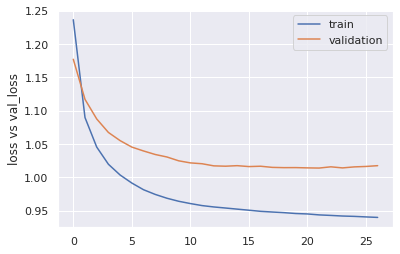

In [ ]:
### START CODE HERE ###
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.ylabel("loss vs val_loss")
plt.legend()
plt.show()

Estado: UNDERFITTING (la skip connection implementada no es muy útil)

### Model Subclassing

#### Entrenamiento

Crear y entrenar una red neuronal que tenga:


*   1 capa de entrada (Identifique que dimensiones debería tener)
*   3 capas ocultas con 16 neuronas cada una y con funcion de activación `ReLu`
*   1 capa de salida con 1 neurona con funcion de activación por defecto (`linear`)


usando [Model Subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models) [2 Pts]

In [ ]:
### START CODE HERE ###  


Parece nuevamente que es lo mismo, pero la diferencia en este caso es que con esto podemos customizar el entrenamiento y muchas cosas más del modelo, pero hay que pagar el precio de trabajar a más bajo nivel.

**Entrene este modelo, grafique las curvas de entrenamiento y evalúe el modelo con el conjunto de testing. Comente los resultados** [0.5 Pts]

In [ ]:
### START CODE HERE ###


#### Evaluación

In [ ]:
### START CODE HERE ###


# 1.2) Ensamblados 📊



Típicamente son tres los métodos más comunes de ensamblado: `Bagging`, `Boosting` y `Stacking`.

**Defina cada uno de los métodos mencionados anteriormente** [2 Pts]


* `Bagging`: Los métodos de bagging son métodos ensamblados donde los algoritmos simples (weak learners) son usados en paralelo (ej: Random Forest).
* `Boosting`: Los métodos de boosting, son métodos ensamblados donde los algoritmos simples son utilizados secuencialmente, es decir, cada modelo simple va delante o detrás de otro modelo simple (ej: Gradient Boosting Trees, símil de Random Forest, pero secuencial).
* `Stacking`: Los métodos de stacking, son métodos ensamblados donde lo que se combina son learners heterogéneos, es decir, si antes juntabamos solo learners de un tipo (como en Random Forest o Gradient Boosting Trees, que utilizan árboles de decisión), ahora podemos juntar árboles con redes neuronales, regresiones, etc. Stacking normalmente incluye modelos de bagging y boosting. 

## Redes neuronales

**Cree un ensamblado de tipo `Bagging` utilizando los modelos creados con `Sequential API`, `Functional API` y `Model Subclassing`. Muestre el ensamble utilizando `tf.keras.utils.plot_model`, entrénelo, grafique las curvas de entrenamiento y evalúelo en el conjunto de testing. Comente los resultados** [4 Pts]

Recuerde congelar los parámetros de estos modelos luego de ser entrenados para ser utilizados en el ensamble, utilice `model.trainable=False` para congelar los parámetros.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            881         ['input_1[0][0]']                
                                                                                                  
 Functional_API_Model (Function  (None, 1)           881         ['input_1[0][0]']                
 al)                                                                                              
                                                                                                  
 average (Average)              (None, 1)            0           ['sequential[0][0]',         

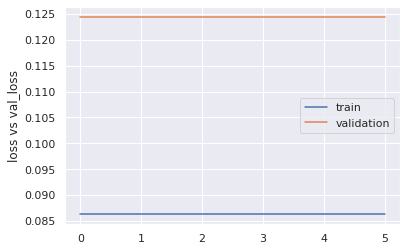

In [ ]:
### START CODE HERE ###
tf.keras.backend.clear_session()  # Reseteo sencillo

models = [s_model, f_model]
model_input = tf.keras.Input(shape=(19,))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

s_model.trainable=False
f_model.trainable=False

ensemble_model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss = "mse",
    metrics = ["mse"]
)


checkpoint_filepath = '/tmp/checkpoint'
callback_list =  [
                      EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
                      ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, save_weights_only=True)
]

ensemble_model.summary()
history = ensemble_model.fit(pp_train_dataset, validation_data=pp_valid_dataset, epochs=50, verbose=2, callbacks=callback_list)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.ylabel("loss vs val_loss")
plt.legend()
plt.show()

## Modelos clásicos (Random Forest, XGBoost y CatBoost)

**Realizar un ensamble de tipo `Stacking` considerando el mismo dataset de house prediction. Para ello entrene 3 modelos distintos: `Random Forest`, `XGBoost` y `CatBoost`. Evalúe el ensamble en el conjunto de testing y comente los resultados** [4 Pts]

In [ ]:
### START CODE HERE ###


# 2) Desafío 🏆



[House Price Prediction](https://www.kaggle.com/t/82ab64ccf77248e9bce30924e6f58459)

<img src="https://drive.google.com/uc?id=1ep729kaGruTMz7Iz6MSnWrfyAy-y4OL9" width="60%"/>


**La nota de este apartado se hará en base a la posición del ranking obtenido en la plataforma `Kaggle`** [60 Pts]

*Todo el código tiene que estar presente en ese apartado incluyendo la generación del archivo para subirlo a la plataforma, pueden agregar la cantidad de celdas que requieran y se valora que incluyan comentarios a los resultados obtenidos* 

---
**Utilizar todo lo aprendido en las tareas incluyendo esta última**

In [ ]:
#Importar los modelos utiliados
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#Cargar datos para train y test
PATH_TO_CSV = os.path.join(path, "house_train.csv")
df_data = pd.read_csv(PATH_TO_CSV)
PATH_TO_CSV = os.path.join(path, "house_test.csv")
df_test = pd.read_csv(PATH_TO_CSV)

In [ ]:
#visualizar datos
df_data.head()

,property_id,room,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,...,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,cctv/security,lift,neighbourhood
0,136863,3.0,RK,Apartment,Sector 20 Ulwe,18613,1349,Furnished,2,NaN,...,10.0,0,NaN,0,1,0,74452,0.0,1.0,2400
1,185713,2.0,BHK,Independent Floor,Wadgaon Sheri,3698,827,Unfurnished,1,Pune,...,14.0,0,0.0,0,0,0,14792,0.0,1.0,900
2,164671,1.0,RK,Independent House,Kalyan West,3931,634,Unfurnished,1,Mumbai,...,10.0,0,NaN,0,0,0,35379,0.0,1.0,3100
3,45212,2.0,BHK,Apartment,Subham Nagar,13419,2506,Semi-Furnished,2,Chennai,...,15.0,1,0.0,1,1,0,134190,1.0,1.0,3200
4,127074,2.0,BHK,Apartment,Ghatkopar West,31022,2078,Semi-Furnished,2,Mumbai,...,16.0,0,0.0,1,1,1,62044,1.0,1.0,1400


In [ ]:
#Visualizar tipos de datos
df_data.dtypes

property_id           int64
room                float64
layout_type          object
property_type        object
locality             object
price                 int64
area                  int64
furnish_type         object
bathroom              int64
city                 object
parking_spaces        int64
floor               float64
pet_friendly          int64
power_backup        float64
washing_machine       int64
air_conditioner       int64
geyser/solar          int64
security_deposit      int64
cctv/security       float64
lift                float64
neighbourhood         int64
dtype: object

In [ ]:
#Ver que datos faltan
df_data.isna().sum()

property_id             0
room                 5376
layout_type             0
property_type           0
locality                0
price                   0
area                    0
furnish_type            0
bathroom                0
city                 5353
parking_spaces          0
floor                1079
pet_friendly            0
power_backup        10584
washing_machine         0
air_conditioner         0
geyser/solar            0
security_deposit        0
cctv/security        1065
lift                 1074
neighbourhood           0
dtype: int64

In [ ]:
#Funcion para relllenar datos con medianas, y datos ecogidos luego de visualizar la distribucion de estos en kaggle
def preprocesamiento(df_data):
  df_data["room"] = df_data["room"].fillna(2)
  df_data["city"] = df_data["city"].fillna("NoCity")
  df_data["floor"] = df_data["floor"].fillna(2)

  df_data["power_backup"] = df_data["power_backup"].fillna(0)
  df_data["cctv/security"] = df_data["cctv/security"].fillna(0)
  df_data["lift"] = df_data["lift"].fillna(0)
  df_data = df_data.drop('locality', axis=1)
  return df_data

In [ ]:
#Aplicacion de preprocesamiento a los datos
df_test = preprocesamiento(df_test)
df_data = preprocesamiento(df_data)

In [ ]:
#encoder de manera ordinal
enc = OrdinalEncoder()
enc.fit(df_data[['layout_type','furnish_type','city']])

OrdinalEncoder()

In [ ]:
df_data[['layout_type','furnish_type','city']] = enc.transform(df_data[['layout_type','furnish_type','city']])
df_test[['layout_type','furnish_type','city']] = enc.transform(df_test[['layout_type','furnish_type','city']])

In [ ]:
train_y = df_data['price']
train_x = df_data.drop(['property_id', 'price','property_type'], axis = 1)
x1 = df_data.drop(['property_id','property_type', 'price'], axis = 1)
y1 = df_data[['property_id','property_type']]

id = df_test['property_id']
test = df_test.drop(['property_id','property_type'], axis = 1)

In [ ]:
#encoder para property_type
enc2 = OrdinalEncoder()
enc2.fit(y1[['property_id','property_type']])
y1[['property_id','property_type']] = enc2.transform(y1[['property_id','property_type']])
y1 = y1.drop(['property_id'], axis = 1)
train_x['property_type'] = y1['property_type']

In [ ]:
#entrenar el arbol para la seleccion de property_type (Con pruebas se observo que mejora en un 5% el modelo al incluir esta columna)
Tree = DecisionTreeClassifier(random_state=SEED)
Tree.fit(x1,y1)

DecisionTreeClassifier(random_state=2022)

In [ ]:
#Rellenar la columna property_type con las predicciones
test['property_type'] = Tree.predict(test)

In [ ]:
#entrenar la regression lineal
reg = LinearRegression()
reg.fit(train_x,train_y)

LinearRegression()

In [ ]:
#obtencion de resultados y creacion del archivo
df_test['price'] = reg.predict(test)
LnearRegResult= df_test[['property_id','price']]
compression_opts = dict(method='zip',
                        archive_name='out.csv')  
LnearRegResult.to_csv('out.zip', index=False,
          compression=compression_opts) 

Equipo Roko - Score: 0.48483